# Implementing a Deep Learning Spike Sorting Pipeline

The objective of this project is to implement a spike sorting project using deep learning techniques. 

We utilized the following core libraries:
- SpikeInterface is used for handling extracellular data present in NWB files 
- PyTorch is used for building Tensors, data loaders, and neural networks

The general overview of this approach is to create a labeled image dataset which will then be used to train different neural network architectures to detect and sort spikes.

---

## Phase 1: Proof of Principle

The main goal of this initial trial is to investigate if it would be possible to train a model to learn neuronal spiking activity. A large part of this process is to first unpack and understand the data we are working with in order to process it as inputs. We also implement different neural network architectures to test out their effectiveness.

### 1. Exploring the data

There are readily available ground-truth datasets in NWB files which contain spikes that have been manually curated by experts. We are going to use the `sub-CSHL049_ses-c99d53e6-c317-4c53-99ba-070b26673ac4_behavior+ecephys+image.nwb` file which can be downloaded from the DANDI archive:
https://api.dandiarchive.org/api/assets/7e4fa468-349c-44a9-a482-26898682eed1/download/

#### Import SpikeInterface modules

We followed the instructions for using `SpikeInterface` based on this tutorial:
https://github.com/SpikeInterface/spiketutorials/tree/master/Official_Tutorial_SI_0.96_Oct22 

Install the latest version of `SpikeInterface` from source as recommended in the **"From source"** section here: 
https://spikeinterface.readthedocs.io/en/latest/installation.html

In [1]:
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.widgets as sw
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

/global/homes/v/vlavan/.conda/envs/spike_sort_v2/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/global/homes/v/vlavan/.conda/envs/spike_sort_v2/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/global/homes/v/vlavan/.conda/envs/spike_sort_v2/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/global/homes/v/vlavan/.conda/envs/spike_sort_v2/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/global/homes/v/vlavan/.conda/en

In [2]:
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.97.1


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import random

from pathlib import Path
import os
import pickle

import multiprocessing as mp
import psutil
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import torchvision
from torchvision import utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

%matplotlib widget

#### Reading an NWB file

In [4]:
base_folder = Path(".")
nwb_file_path = "sub-CSHL049_ses-c99d53e6-c317-4c53-99ba-070b26673ac4_behavior+ecephys+image.nwb"

In [5]:
recording_nwb = se.read_nwb_recording(file_path=nwb_file_path, electrical_series_name='ElectricalSeriesAp')
recording_nwb

NwbRecordingExtractor: 768 channels - 1 segments - 30.0kHz - 4172.982s
  file_path: /pscratch/sd/v/vlavan/sub-CSHL049_ses-c99d53e6-c317-4c53-99ba-070b26673ac4_behavior+ecephys+image.nwb

In [6]:
recording_nwb.annotate(is_filtered=False)

In [7]:
channel_ids = recording_nwb.get_channel_ids()
print(channel_ids)

['AP0' 'AP1' 'AP2' 'AP3' 'AP4' 'AP5' 'AP6' 'AP7' 'AP8' 'AP9' 'AP10' 'AP11'
 'AP12' 'AP13' 'AP14' 'AP15' 'AP16' 'AP17' 'AP18' 'AP19' 'AP20' 'AP21'
 'AP22' 'AP23' 'AP24' 'AP25' 'AP26' 'AP27' 'AP28' 'AP29' 'AP30' 'AP31'
 'AP32' 'AP33' 'AP34' 'AP35' 'AP36' 'AP37' 'AP38' 'AP39' 'AP40' 'AP41'
 'AP42' 'AP43' 'AP44' 'AP45' 'AP46' 'AP47' 'AP48' 'AP49' 'AP50' 'AP51'
 'AP52' 'AP53' 'AP54' 'AP55' 'AP56' 'AP57' 'AP58' 'AP59' 'AP60' 'AP61'
 'AP62' 'AP63' 'AP64' 'AP65' 'AP66' 'AP67' 'AP68' 'AP69' 'AP70' 'AP71'
 'AP72' 'AP73' 'AP74' 'AP75' 'AP76' 'AP77' 'AP78' 'AP79' 'AP80' 'AP81'
 'AP82' 'AP83' 'AP84' 'AP85' 'AP86' 'AP87' 'AP88' 'AP89' 'AP90' 'AP91'
 'AP92' 'AP93' 'AP94' 'AP95' 'AP96' 'AP97' 'AP98' 'AP99' 'AP100' 'AP101'
 'AP102' 'AP103' 'AP104' 'AP105' 'AP106' 'AP107' 'AP108' 'AP109' 'AP110'
 'AP111' 'AP112' 'AP113' 'AP114' 'AP115' 'AP116' 'AP117' 'AP118' 'AP119'
 'AP120' 'AP121' 'AP122' 'AP123' 'AP124' 'AP125' 'AP126' 'AP127' 'AP128'
 'AP129' 'AP130' 'AP131' 'AP132' 'AP133' 'AP134' 'AP135' 'AP136' 

In [8]:
channel_ids_slice = channel_ids[0:384]
print(channel_ids_slice)

['AP0' 'AP1' 'AP2' 'AP3' 'AP4' 'AP5' 'AP6' 'AP7' 'AP8' 'AP9' 'AP10' 'AP11'
 'AP12' 'AP13' 'AP14' 'AP15' 'AP16' 'AP17' 'AP18' 'AP19' 'AP20' 'AP21'
 'AP22' 'AP23' 'AP24' 'AP25' 'AP26' 'AP27' 'AP28' 'AP29' 'AP30' 'AP31'
 'AP32' 'AP33' 'AP34' 'AP35' 'AP36' 'AP37' 'AP38' 'AP39' 'AP40' 'AP41'
 'AP42' 'AP43' 'AP44' 'AP45' 'AP46' 'AP47' 'AP48' 'AP49' 'AP50' 'AP51'
 'AP52' 'AP53' 'AP54' 'AP55' 'AP56' 'AP57' 'AP58' 'AP59' 'AP60' 'AP61'
 'AP62' 'AP63' 'AP64' 'AP65' 'AP66' 'AP67' 'AP68' 'AP69' 'AP70' 'AP71'
 'AP72' 'AP73' 'AP74' 'AP75' 'AP76' 'AP77' 'AP78' 'AP79' 'AP80' 'AP81'
 'AP82' 'AP83' 'AP84' 'AP85' 'AP86' 'AP87' 'AP88' 'AP89' 'AP90' 'AP91'
 'AP92' 'AP93' 'AP94' 'AP95' 'AP96' 'AP97' 'AP98' 'AP99' 'AP100' 'AP101'
 'AP102' 'AP103' 'AP104' 'AP105' 'AP106' 'AP107' 'AP108' 'AP109' 'AP110'
 'AP111' 'AP112' 'AP113' 'AP114' 'AP115' 'AP116' 'AP117' 'AP118' 'AP119'
 'AP120' 'AP121' 'AP122' 'AP123' 'AP124' 'AP125' 'AP126' 'AP127' 'AP128'
 'AP129' 'AP130' 'AP131' 'AP132' 'AP133' 'AP134' 'AP135' 'AP136' 

In [9]:
recording_slice = recording_nwb.channel_slice(channel_ids=channel_ids_slice)
recording_slice

ChannelSliceRecording: 384 channels - 1 segments - 30.0kHz - 4172.982s

In [10]:
sw.plot_timeseries(recording_slice, order_channel_by_depth=True, backend="ipywidgets",
                          clim=(-200, 200))

AppLayout(children=(VBox(children=(FloatSlider(value=0.0, continuous_update=False, description='time:', layout…

In [11]:
sorting_nwb = se.read_nwb_sorting(file_path=nwb_file_path, electrical_series_name='ElectricalSeriesAp')
sorting_nwb

NwbSortingExtractor: 423 units - 1 segments - 30.0kHz
  file_path: /pscratch/sd/v/vlavan/sub-CSHL049_ses-c99d53e6-c317-4c53-99ba-070b26673ac4_behavior+ecephys+image.nwb

#### Preprocessing the recording

In [12]:
recording_f = spre.bandpass_filter(recording_slice, freq_min=300, freq_max=6000)
recording_f

BandpassFilterRecording: 384 channels - 1 segments - 30.0kHz - 4172.982s

In [13]:
recording_cmr = spre.common_reference(recording_f, reference='global', operator='median')
recording_cmr

CommonReferenceRecording: 384 channels - 1 segments - 30.0kHz - 4172.982s

#### Inspecting probe channels

In [14]:
channel_ids = recording_cmr.get_channel_ids()
print(channel_ids)

['AP0' 'AP1' 'AP2' 'AP3' 'AP4' 'AP5' 'AP6' 'AP7' 'AP8' 'AP9' 'AP10' 'AP11'
 'AP12' 'AP13' 'AP14' 'AP15' 'AP16' 'AP17' 'AP18' 'AP19' 'AP20' 'AP21'
 'AP22' 'AP23' 'AP24' 'AP25' 'AP26' 'AP27' 'AP28' 'AP29' 'AP30' 'AP31'
 'AP32' 'AP33' 'AP34' 'AP35' 'AP36' 'AP37' 'AP38' 'AP39' 'AP40' 'AP41'
 'AP42' 'AP43' 'AP44' 'AP45' 'AP46' 'AP47' 'AP48' 'AP49' 'AP50' 'AP51'
 'AP52' 'AP53' 'AP54' 'AP55' 'AP56' 'AP57' 'AP58' 'AP59' 'AP60' 'AP61'
 'AP62' 'AP63' 'AP64' 'AP65' 'AP66' 'AP67' 'AP68' 'AP69' 'AP70' 'AP71'
 'AP72' 'AP73' 'AP74' 'AP75' 'AP76' 'AP77' 'AP78' 'AP79' 'AP80' 'AP81'
 'AP82' 'AP83' 'AP84' 'AP85' 'AP86' 'AP87' 'AP88' 'AP89' 'AP90' 'AP91'
 'AP92' 'AP93' 'AP94' 'AP95' 'AP96' 'AP97' 'AP98' 'AP99' 'AP100' 'AP101'
 'AP102' 'AP103' 'AP104' 'AP105' 'AP106' 'AP107' 'AP108' 'AP109' 'AP110'
 'AP111' 'AP112' 'AP113' 'AP114' 'AP115' 'AP116' 'AP117' 'AP118' 'AP119'
 'AP120' 'AP121' 'AP122' 'AP123' 'AP124' 'AP125' 'AP126' 'AP127' 'AP128'
 'AP129' 'AP130' 'AP131' 'AP132' 'AP133' 'AP134' 'AP135' 'AP136' 

In [15]:
channel_locations = recording_cmr.get_channel_locations()
print(channel_locations)

[[  16.    0.]
 [  48.    0.]
 [   0.   20.]
 [  32.   20.]
 [  16.   40.]
 [  48.   40.]
 [   0.   60.]
 [  32.   60.]
 [  16.   80.]
 [  48.   80.]
 [   0.  100.]
 [  32.  100.]
 [  16.  120.]
 [  48.  120.]
 [   0.  140.]
 [  32.  140.]
 [  16.  160.]
 [  48.  160.]
 [   0.  180.]
 [  32.  180.]
 [  16.  200.]
 [  48.  200.]
 [   0.  220.]
 [  32.  220.]
 [  16.  240.]
 [  48.  240.]
 [   0.  260.]
 [  32.  260.]
 [  16.  280.]
 [  48.  280.]
 [   0.  300.]
 [  32.  300.]
 [  16.  320.]
 [  48.  320.]
 [   0.  340.]
 [  32.  340.]
 [  16.  360.]
 [  48.  360.]
 [   0.  380.]
 [  32.  380.]
 [  16.  400.]
 [  48.  400.]
 [   0.  420.]
 [  32.  420.]
 [  16.  440.]
 [  48.  440.]
 [   0.  460.]
 [  32.  460.]
 [  16.  480.]
 [  48.  480.]
 [   0.  500.]
 [  32.  500.]
 [  16.  520.]
 [  48.  520.]
 [   0.  540.]
 [  32.  540.]
 [  16.  560.]
 [  48.  560.]
 [   0.  580.]
 [  32.  580.]
 [  16.  600.]
 [  48.  600.]
 [   0.  620.]
 [  32.  620.]
 [  16.  640.]
 [  48.  640.]
 [   0.  6

In [16]:
channel_summary = np.hstack((channel_ids.reshape(-1,1), channel_locations))
print(channel_summary)

[['AP0' '16.0' '0.0']
 ['AP1' '48.0' '0.0']
 ['AP2' '0.0' '20.0']
 ...
 ['AP381' '48.0' '3800.0']
 ['AP382' '0.0' '3820.0']
 ['AP383' '32.0' '3820.0']]


In [17]:
column_names = ['channel_id', 'channel_loc_x', 'channel_loc_y']

channel_summary_table = pd.DataFrame(channel_summary, columns=column_names)
display(channel_summary_table)

,channel_id,channel_loc_x,channel_loc_y
0,AP0,16.0,0.0
1,AP1,48.0,0.0
2,AP2,0.0,20.0
3,AP3,32.0,20.0
4,AP4,16.0,40.0
...,...,...,...
379,AP379,32.0,3780.0
380,AP380,16.0,3800.0
381,AP381,48.0,3800.0
382,AP382,0.0,3820.0


In [18]:
channel_summary_table['channel_loc_x'].unique()

array(['16.0', '48.0', '0.0', '32.0'], dtype=object)

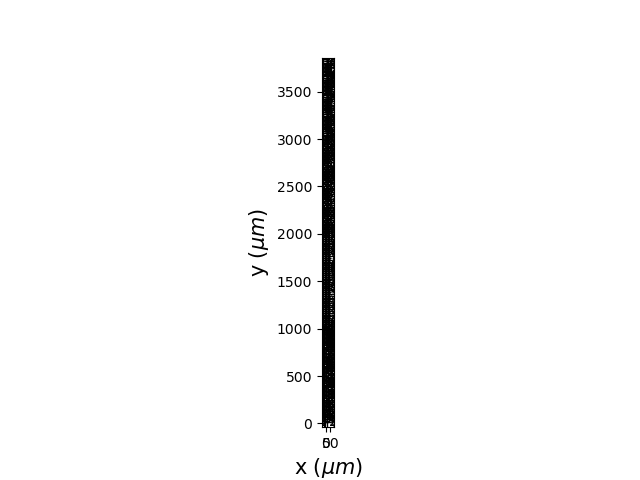

In [19]:
sw.plot_probe_map(recording_cmr, with_channel_ids=True)

#### Inspecting spike events

Since we are using an NWB file that contains both the raw recording and spike sorted data, we can extract information of the already sorted spikes.

We need these expert-sorted spikes in order to determine the best channels and frames for plotting our images and labelling them as spikes for training.

Before we are able to retrieve information about these spikes, we need to create a `WaveformExtractor` object which has mechanisms provided by `SpikeInterface` for computing the spike locations as well as plotting them on the probe.

A `WaveformExtractor` object requires a paired `Recording` and `Sorting object` which we already have.

More information on waveform extractors can be found here:
https://spikeinterface.readthedocs.io/en/latest/modules_gallery/core/plot_4_waveform_extractor.html

In [20]:
waveform_folder = 'waveform'

job_kwargs = dict(n_jobs=10, chunk_duration="1s", progress_bar=True)

In [21]:
if (base_folder / waveform_folder).is_dir():
    waveform = si.load_waveforms(base_folder / waveform_folder)
else:
    waveform = si.extract_waveforms(
        recording_cmr,
        sorting_nwb,
        waveform_folder,
        ms_before=1.5,
        ms_after=2.,
        max_spikes_per_unit=None,
        overwrite=True,
        **job_kwargs
    )

In [22]:
waveform

WaveformExtractor: 384 channels - 423 units - 1 segments
  before:45 after:60 n_per_units:None

We can retrieve the frames each spike occurred (since `SpikeInterface` uses frames instead of seconds) by using the `get_all_spike_trains()` function which returns a list containing two arrays including each spike's unit ID and frame.

Each individual spike frame is the rounded product of its corresponding spike time and the sampling frequency.

In [23]:
print(sorting_nwb.get_all_spike_trains())

[(array([      471,       511,       606, ..., 125188911, 125188967,
       125189063]), array([  0,   1,   2, ..., 102, 316,  69]))]


In [24]:
spikes_table = pd.DataFrame({'unit_id':sorting_nwb.get_all_spike_trains()[0][1], 'spike_frame':sorting_nwb.get_all_spike_trains()[0][0]})
spikes_table['unit_id'] = spikes_table['unit_id'].astype(int)

display(spikes_table)

,unit_id,spike_frame
0,0,471
1,1,511
2,2,606
3,1,680
4,3,715
...,...,...
4604408,372,125188815
4604409,41,125188837
4604410,102,125188911
4604411,316,125188967


In [25]:
print(si.get_template_extremum_channel(waveform, outputs="index"))

{0: 341, 1: 361, 2: 354, 3: 325, 4: 348, 5: 350, 6: 299, 7: 300, 8: 292, 9: 224, 10: 300, 11: 149, 12: 330, 13: 325, 14: 361, 15: 281, 16: 329, 17: 330, 18: 338, 19: 150, 20: 301, 21: 314, 22: 301, 23: 77, 24: 110, 25: 338, 26: 329, 27: 285, 28: 330, 29: 225, 30: 56, 31: 211, 32: 152, 33: 276, 34: 146, 35: 176, 36: 329, 37: 316, 38: 50, 39: 261, 40: 134, 41: 155, 42: 124, 43: 173, 44: 177, 45: 17, 46: 213, 47: 217, 48: 307, 49: 98, 50: 15, 51: 78, 52: 258, 53: 334, 54: 338, 55: 257, 56: 221, 57: 334, 58: 364, 59: 362, 60: 141, 61: 277, 62: 293, 63: 338, 64: 287, 65: 106, 66: 79, 67: 362, 68: 278, 69: 157, 70: 7, 71: 130, 72: 174, 73: 10, 74: 298, 75: 278, 76: 305, 77: 336, 78: 330, 79: 111, 80: 354, 81: 168, 82: 170, 83: 345, 84: 339, 85: 141, 86: 10, 87: 137, 88: 69, 89: 306, 90: 169, 91: 318, 92: 280, 93: 329, 94: 330, 95: 263, 96: 329, 97: 276, 98: 353, 99: 334, 100: 334, 101: 338, 102: 325, 103: 209, 104: 324, 105: 345, 106: 337, 107: 342, 108: 354, 109: 63, 110: 326, 111: 354, 112

In [26]:
# Create a new column and map values from the dictionary based on matching keys
spikes_table['extremum_channel'] = spikes_table['unit_id'].map(si.get_template_extremum_channel(waveform, outputs="index"))
spikes_table['spike_number'] = range(len(spikes_table))

display(spikes_table)

,unit_id,spike_frame,extremum_channel,spike_number
0,0,471,341,0
1,1,511,361,1
2,2,606,354,2
3,1,680,361,3
4,3,715,325,4
...,...,...,...,...
4604408,372,125188815,21,4604408
4604409,41,125188837,155,4604409
4604410,102,125188911,325,4604410
4604411,316,125188967,326,4604411


In [27]:
spike_frame = 471
trace_snippet = recording_cmr.get_traces(start_frame=spike_frame-31, end_frame=spike_frame+33)

In [28]:
trace_snippet.shape

(64, 384)

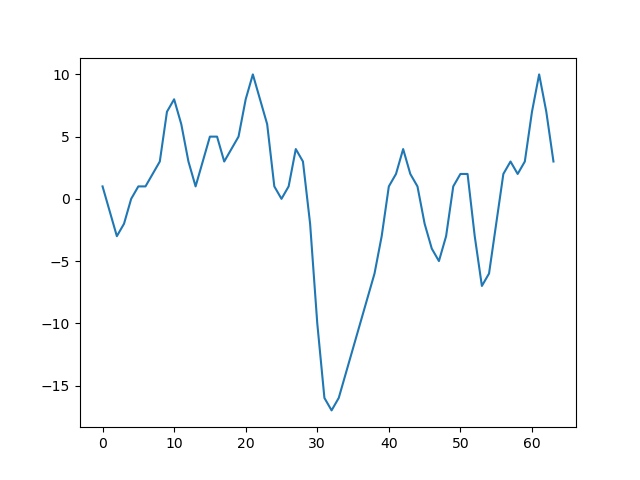

In [29]:
plt.figure()
plt.plot(trace_snippet[:, 341])

In [30]:
def plot_spike_unit(unit_id, num_spikes):
    spike_unit = spikes_table[spikes_table['unit_id']==unit_id]
    spike_frames = spike_unit['spike_frame'].to_list()
    spike_frames_random = random.sample(spike_frames, num_spikes)
    extremum_channel = spike_unit['extremum_channel'].unique()[0]
    print("Unit name:", unit_id)
    print("\nExtremum channel:", extremum_channel)
    
    plt.figure(figsize=(10, 5))
    
    for spike_frame in spike_frames_random:
        # Get the trace
        trace_snippet = recording_cmr.get_traces(start_frame=spike_frame-31, end_frame=spike_frame+32)
        
        plt.plot(trace_snippet[:, extremum_channel])
        
    plt.xlabel('time (frames)')
    plt.ylabel('amplitude')
    plt.show()

Unit name: 9

Extremum channel: 224


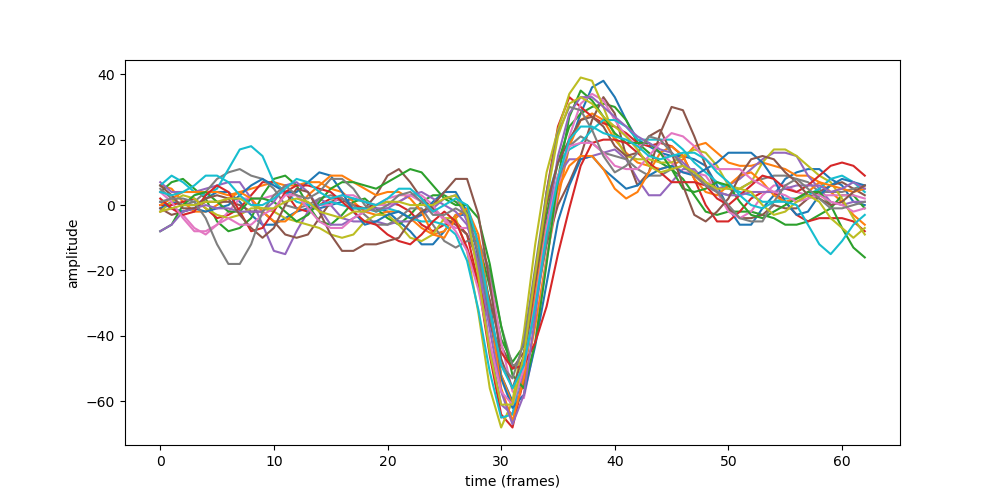

In [31]:
plot_spike_unit(9, 20)

Because of how the channels on a Neuropixels probe are arranged in a checkerboard pattern, we want to reshape our trace to better emulate that. This would mean separating the channels into two columns resulting in a 3-dimensional array.

In [32]:
trace_reshaped = np.dstack((
    trace_snippet[:, ::2],
    trace_snippet[:, 1::2]
))

trace_reshaped.shape

(64, 192, 2)

In [33]:
trace_transposed = np.transpose(trace_reshaped, (1, 0, 2))
trace_transposed.shape

(192, 64, 2)

In [34]:
vmin = trace_transposed.min()
vmax = trace_transposed.max()
print('Min: ', vmin, '\nMax: ', vmax)

Min:  -47 
Max:  48


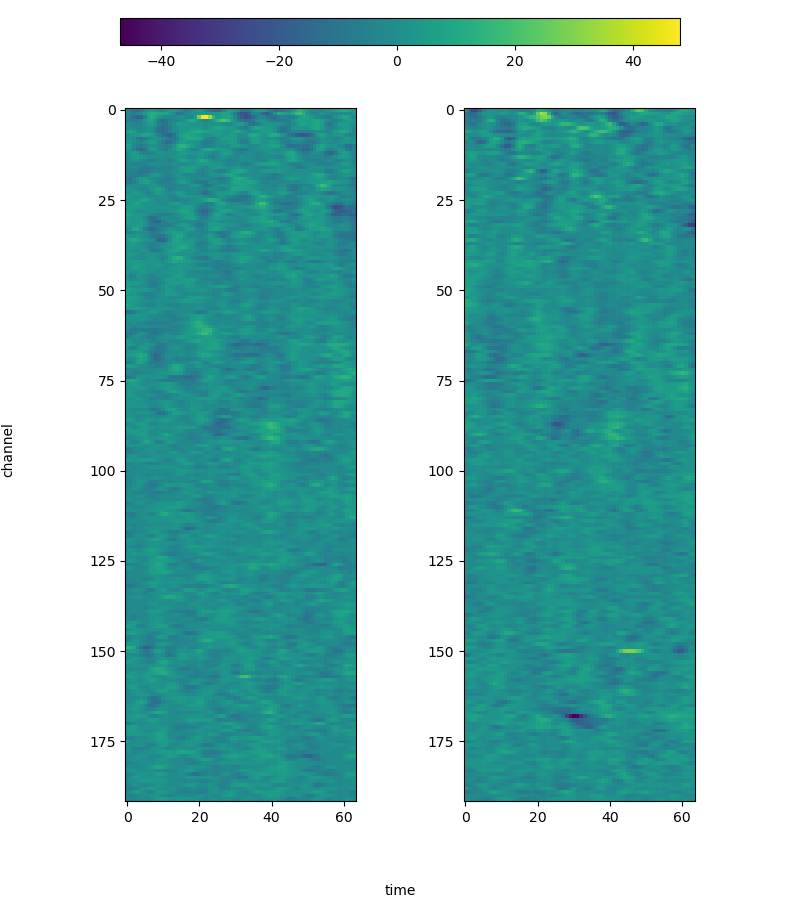

In [35]:
plt.figure(figsize=(8, 9))
for i in range(trace_reshaped.shape[2]):
    plt.subplot(1, 2, i+1)
    plt.imshow(trace_transposed[:, :, i], cmap='viridis', vmin=vmin, vmax=vmax)
# Set x and y labels for the whole plot
plt.text(0.5, 0.01, 'time', ha='center', va='center', transform=plt.gcf().transFigure)
plt.text(0.01, 0.5, 'channel', ha='center', va='center', rotation='vertical', transform=plt.gcf().transFigure)
# Add colorbar for the whole plot
cax = plt.axes([0.15, 0.95, 0.7, 0.03])  # [left, bottom, width, height]
cb = plt.colorbar(cax=cax, orientation='horizontal')

### 2. Creating the dataset

In [36]:
dataset_folder_path = os.path.join(os.getcwd(), "dataset")

if not os.path.exists(dataset_folder_path):
    os.mkdir(dataset_folder_path)

In [37]:
nthreads = psutil.cpu_count(logical=True)
ncores = psutil.cpu_count(logical=False)
nthreads_per_core = nthreads // ncores
nthreads_available = len(os.sched_getaffinity(0))
ncores_available = nthreads_available // nthreads_per_core

assert nthreads == os.cpu_count()
assert nthreads == mp.cpu_count()

print(f'{nthreads=}')
print(f'{ncores=}')
print(f'{nthreads_per_core=}')
print(f'{nthreads_available=}')
print(f'{ncores_available=}')

nthreads=256
ncores=128
nthreads_per_core=2
nthreads_available=256
ncores_available=128


#### Process spike events as numpy files

In order to obtain a fairly large dataset of spikes for our model, we want to select units which have at least 1000 spikes within them.

In [38]:
top_spike_units = spikes_table['unit_id'].value_counts()
top_spike_units = top_spike_units[top_spike_units >= 1000]
print(top_spike_units)

unit_id
86     143422
73     102798
13      91008
202     75087
36      71827
        ...  
397      1091
6        1081
279      1058
255      1036
192      1006
Name: count, Length: 312, dtype: int64


In [39]:
top_spike_units_table = spikes_table[spikes_table['unit_id'].isin(top_spike_units.index)]
top_spike_units_table = top_spike_units_table.sort_values(by=['unit_id', 'spike_frame'], ascending=True)
display(top_spike_units_table)

,unit_id,spike_frame,extremum_channel,spike_number
0,0,471,341,0
48,0,3743,341,48
107,0,9046,341,107
451,0,37231,341,451
461,0,37632,341,461
...,...,...,...,...
3385508,397,93597726,4,3385508
3385512,397,93597801,4,3385512
3417725,397,94493702,4,3417725
3912623,397,108015841,4,3912623


In [40]:
top_spike_units = top_spike_units_table['unit_id'].unique()
print('Number of units:', len(top_spike_units))
print(top_spike_units)

Number of units: 312
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 146
 147 148 149 150 151 152 153 154 155 156 157 159 160 161 162 163 164 165
 166 167 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 191 192 194 196 198 200 201 202 203 204 206 207 208
 209 210 212 213 214 216 217 218 219 220 221 225 226 227 228 229 230 231
 232 233 235 236 237 238 239 240 241 243 244 245 246 247 250 252 254 255
 256 257 259 260 261 262 263 2

Since we are running this project on NERSC, we are able to utilize multiprocessing as well as batches in order to speed up the process of generating our dataset.

In [41]:
def is_folder_empty(folder_path):
    return not bool(os.listdir(folder_path))

In [42]:
def process_spikes(frames_paths):
    for frame, path in frames_paths:
        # Get the trace
        spike_trace = recording_cmr.get_traces(start_frame=frame - 31, end_frame=frame + 33)
        spike_trace_reshaped = np.dstack((
            spike_trace[:, ::2],
            spike_trace[:, 1::2]
        ))

        # Save the numpy array to disk
        file_name = f"frame_{frame}"
        np.save(os.path.join(path, file_name), spike_trace_reshaped)

In [43]:
def process_spikes_batches(batch, path):
    frames_paths_batch = [(frame, path) for frame in batch]
    process_numpy_files(frames_paths_batch)

In [44]:
if is_folder_empty(dataset_folder_path):
    # Define the number of processes
    num_processes = 128

    # Create a multiprocessing pool
    pool = mp.Pool(processes=num_processes)

    # Iterate over the units
    for unit in top_spike_units:
        unit_folder_path = os.path.join(dataset_folder_path, f"unit_{unit}")
        if not os.path.exists(unit_folder_path):
            os.mkdir(unit_folder_path)

        unit_table = top_spike_units_table[top_spike_units_table['unit_id'] == unit]
        unit_table = unit_table.reset_index()

        # Set the number of frames to use from the unit
        num_frames = 1000

        # Iterate over the frames in batches
        for i in range(0, num_frames, batch_size):
            frames_batch = unit_table['spike_frame'][i:i+batch_size]

            # Apply multiprocessing to process the batch of frames
            pool.apply_async(process_spikes_batches, args=(frames_batch, unit_path))

    # Close the pool and wait for the processes to finish
    pool.close()
    pool.join()

#### Process noise as numpy files

In order to obtain our noise dataset, we can select frames that exist in gaps between each of our spikes.

In [45]:
noise_folder_path = os.path.join(dataset_folder_path, "noise")

if not os.path.exists(noise_folder_path):
    os.mkdir(noise_folder_path)
    
    spike_frames = spikes_table['spike_frame'].to_list()
    noise_frames = [noise_frame - 64 for noise_frame in spike_frames]
    print(noise_frames)

In [46]:
def process_noise(noise_frame, noise_folder_path):
    # Get the trace
    noise_trace = recording_cmr.get_traces(start_frame=noise_frame - 31, end_frame=noise_frame + 33)
    noise_trace_reshaped = np.dstack((
        noise_trace[:, ::2],
        noise_trace[:, 1::2]
    ))

    # Save the numpy array to disk
    file_name = f"frame_{noise_frame}"
    np.save(os.path.join(noise_folder_path, file_name), noise_trace_reshaped)

In [47]:
if is_folder_empty(noise_folder_path):
    # Define the number of processes
    num_processes = 128

    # Create a multiprocessing pool
    pool = mp.Pool(processes=num_processes)

    # Set the number of frames
    num_frames = 100000

    # Iterate over the frames
    for i in range(0, num_frames):
        noise_frame = noise_frames[i]

        # Apply multiprocessing to process the frame
        pool.apply_async(process_noise, args=(noise_frame, noise_path))

    # Close the multiprocessing pool
    pool.close()
    pool.join()

#### Convert to tensor dataset

In [48]:
dataset_folders = ['unit_' + str(unit) for unit in top_spike_units[:100]]
dataset_folders.append("noise")
print(dataset_folders)

['unit_0', 'unit_1', 'unit_2', 'unit_3', 'unit_4', 'unit_5', 'unit_6', 'unit_7', 'unit_8', 'unit_9', 'unit_10', 'unit_11', 'unit_12', 'unit_13', 'unit_14', 'unit_15', 'unit_16', 'unit_17', 'unit_18', 'unit_19', 'unit_20', 'unit_21', 'unit_22', 'unit_23', 'unit_24', 'unit_25', 'unit_26', 'unit_27', 'unit_28', 'unit_29', 'unit_30', 'unit_31', 'unit_32', 'unit_33', 'unit_34', 'unit_35', 'unit_36', 'unit_37', 'unit_38', 'unit_39', 'unit_40', 'unit_41', 'unit_42', 'unit_43', 'unit_44', 'unit_45', 'unit_46', 'unit_47', 'unit_48', 'unit_49', 'unit_50', 'unit_51', 'unit_52', 'unit_53', 'unit_54', 'unit_55', 'unit_56', 'unit_57', 'unit_58', 'unit_59', 'unit_60', 'unit_61', 'unit_62', 'unit_63', 'unit_64', 'unit_65', 'unit_66', 'unit_67', 'unit_68', 'unit_69', 'unit_70', 'unit_71', 'unit_72', 'unit_73', 'unit_74', 'unit_75', 'unit_76', 'unit_77', 'unit_78', 'unit_79', 'unit_80', 'unit_81', 'unit_82', 'unit_83', 'unit_84', 'unit_85', 'unit_86', 'unit_87', 'unit_88', 'unit_89', 'unit_90', 'unit_91

In [49]:
dataset_folders_dict = {name: index for index, name in enumerate(dataset_folders)}
print(dataset_folders_dict)

{'unit_0': 0, 'unit_1': 1, 'unit_2': 2, 'unit_3': 3, 'unit_4': 4, 'unit_5': 5, 'unit_6': 6, 'unit_7': 7, 'unit_8': 8, 'unit_9': 9, 'unit_10': 10, 'unit_11': 11, 'unit_12': 12, 'unit_13': 13, 'unit_14': 14, 'unit_15': 15, 'unit_16': 16, 'unit_17': 17, 'unit_18': 18, 'unit_19': 19, 'unit_20': 20, 'unit_21': 21, 'unit_22': 22, 'unit_23': 23, 'unit_24': 24, 'unit_25': 25, 'unit_26': 26, 'unit_27': 27, 'unit_28': 28, 'unit_29': 29, 'unit_30': 30, 'unit_31': 31, 'unit_32': 32, 'unit_33': 33, 'unit_34': 34, 'unit_35': 35, 'unit_36': 36, 'unit_37': 37, 'unit_38': 38, 'unit_39': 39, 'unit_40': 40, 'unit_41': 41, 'unit_42': 42, 'unit_43': 43, 'unit_44': 44, 'unit_45': 45, 'unit_46': 46, 'unit_47': 47, 'unit_48': 48, 'unit_49': 49, 'unit_50': 50, 'unit_51': 51, 'unit_52': 52, 'unit_53': 53, 'unit_54': 54, 'unit_55': 55, 'unit_56': 56, 'unit_57': 57, 'unit_58': 58, 'unit_59': 59, 'unit_60': 60, 'unit_61': 61, 'unit_62': 62, 'unit_63': 63, 'unit_64': 64, 'unit_65': 65, 'unit_66': 66, 'unit_67': 67,

In [50]:
class TensorDataset(Dataset):
    def __init__(self, folder_path, num_spike_files=1000, num_noise_files=1000):
        self.folder_path = folder_path
        self.file_paths = self.get_file_paths(num_spike_files, num_noise_files)
        self.label_map = dataset_folders_dict

    def get_file_paths(self, num_spike_files, num_noise_files):
        file_paths = []
        # Iterate over the subfolders
        for folder in dataset_folders:
            folder_path = os.path.join(self.folder_path, folder)
            # Get all the numpy files in the subfolder
            folder_files = [file for file in os.listdir(folder_path) if file.endswith('.npy')]
            # Add the full path of each file to the list
            if folder == 'noise':
                # Select a number of files from the noise folder
                file_paths.extend([os.path.join(folder_path, file) for file in folder_files[:num_noise_files]])
            else:
                # Select a number of files from each spike unit folder
                file_paths.extend([os.path.join(folder_path, file) for file in folder_files[:num_spike_files]])
        return file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load the numpy file as a grayscale image tensor
        image = torch.from_numpy(np.load(self.file_paths[idx])).unsqueeze(0).float()
        # Extract the folder name from the file path
        folder_name = os.path.dirname(self.file_paths[idx])
        # Extract the label from the folder name
        label = folder_name.split(os.sep)[-1]  # Extract the last folder name
        # Assign the numerical label based on the label map
        label = self.label_map[label]
        return image, label

In [52]:
spikes_dataset = TensorDataset(dataset_folder_path)

#### Split for training and testing

In [53]:
#split data to test and train
#use 80% to train
train_size = int(0.7 * len(spikes_dataset))
test_size = len(spikes_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(spikes_dataset, [train_size, test_size])

print("Training size:", len(train_dataset))
print("Testing size:",len(test_dataset))

Training size: 70700
Testing size: 30300


In [54]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=2,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    num_workers=2,
    shuffle=True
)

### 3. Implementing a neural network architecture

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [56]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Conv3d(1, 32, kernel_size=(16, 4, 2)) 
        self.conv_layer_2 = nn.Conv2d(32, 64, kernel_size=2) 
        self.conv_layer_3 = nn.Conv2d(64, 128, kernel_size=2)
        self.conv_layer_2_drop = nn.Dropout2d()
        self.conv_layer_3_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fully_connected_layer_1 = nn.Linear(14080, 500)
        self.fully_connected_layer_2 = nn.Linear(500, 101)


    def forward(self, x):
        x = F.relu(F.max_pool2d(torch.squeeze(self.conv_layer_1(x), 4), 2))
        
        x = F.relu(F.max_pool2d(self.conv_layer_2_drop(self.conv_layer_2(x)), 2))
        
        x = F.relu(F.max_pool2d(self.conv_layer_3_drop(self.conv_layer_3(x)), 2))
        
        x = self.flatten(x)
        x = F.relu(self.fully_connected_layer_1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fully_connected_layer_2(x))
        return F.log_softmax(x,dim=1)

model = CNNet().to(device)

In [57]:
summary(model, input_size=(64, 1, 64, 192, 2))

Layer (type:depth-idx)                   Output Shape              Param #
CNNet                                    [64, 101]                 --
├─Conv3d: 1-1                            [64, 32, 49, 189, 1]      4,128
├─Conv2d: 1-2                            [64, 64, 23, 93]          8,256
├─Dropout2d: 1-3                         [64, 64, 23, 93]          --
├─Conv2d: 1-4                            [64, 128, 10, 45]         32,896
├─Dropout2d: 1-5                         [64, 128, 10, 45]         --
├─Flatten: 1-6                           [64, 14080]               --
├─Linear: 1-7                            [64, 500]                 7,040,500
├─Linear: 1-8                            [64, 101]                 50,601
Total params: 7,136,381
Trainable params: 7,136,381
Non-trainable params: 0
Total mult-adds (G): 4.98
Input size (MB): 6.29
Forward/backward pass size (MB): 251.62
Params size (MB): 28.55
Estimated Total Size (MB): 286.46

### 4. Training and testing the model

In [58]:
models_folder_path = os.path.join(os.getcwd(), "models")

if not os.path.exists(models_folder_path):
    os.mkdir(models_folder_path)

In [59]:
# create optimal parameters
cost = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
# Create training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):
        X = X.to(device)
        Y = Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, Y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss_value = loss.item()
            current = batch * len(X)
            print(f'loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]')

# Create testing/validation function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += loss_fn(pred, Y).item()
            correct += (pred.argmax(1) == Y).type(torch.float).sum().item()

            true_labels.extend(Y.tolist())
            predicted_labels.extend(pred.argmax(1).tolist())

    test_loss /= size
    correct /= size

    print(f'\nTest Error:\nacc: {(100 * correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

    return test_loss, true_labels, predicted_labels

In [72]:
def train_test_model(model, model_name, epochs, start_epoch, losses, accuracies, checkpoint_file_path):
    try:
        for epoch in range(start_epoch, epochs):
            print(f'Epoch {epoch+1}\n-------------------------------')

            # Train the model and get the losses for this epoch
            train_losses = train(train_dataloader, model, cost, optimizer)

            # Test the model and get the accuracy for this epoch
            test_loss, true_labels, predicted_labels = test(test_dataloader, model, cost)
            losses.append(test_loss)
            accuracy = accuracy_score(true_labels, predicted_labels)
            accuracies.append(accuracy)  # Append the accuracy within the loop

            # Plotting the training loss and accuracy after each epoch
            plt.figure()
            plt.plot(losses, label='Training Loss')
            plt.plot(accuracies, label='Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Value')
            plt.title(f'Training Loss and Accuracy over Time ({epoch+1} Epochs)')
            plt.legend()
            plt.savefig(os.path.join(models_folder_path, f'{model_name}_loss_accuracy.png'))
            plt.close()

            # Plot confusion matrix
            classes = list(range(0, 101))
            cm = confusion_matrix(true_labels, predicted_labels)
            plt.figure(figsize=(50, 50))
            sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
            plt.title(f'Confusion Matrix ({epoch+1} Epochs)')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.savefig(os.path.join(models_folder_path, f'{model_name}_confusion_matrix.png'))
            plt.close()

            # Save the checkpoint after each epoch
            save_checkpoint(model, epoch+1, losses, accuracies, checkpoint_file_path)

    except KeyboardInterrupt:
        print('Training paused by user.')
        # Save the checkpoint when the training is paused
        save_checkpoint(model, epoch, losses, accuracies, checkpoint_file_path)

    print('Training completed.')

In [62]:
# Save a checkpoint
def save_checkpoint(model, epoch, losses, accuracies, checkpoint_file_path):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'end_epoch': epoch,
        'losses': losses,
        'accuracies': accuracies
    }
    torch.save(checkpoint, checkpoint_file_path)
    print(f'Checkpoint saved: {checkpoint_file_path}')

# Load a checkpoint
def load_checkpoint(model, checkpoint_file_path):
    if os.path.exists(checkpoint_file_path):
        checkpoint = torch.load(checkpoint_file_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        start_epoch = checkpoint['end_epoch']
        losses = checkpoint['losses']
        accuracies = checkpoint['accuracies']
        print(f'Checkpoint loaded: {checkpoint_file_path}\n')
        print(f'Training ended at epoch {start_epoch}\n')
        return model, start_epoch, losses, accuracies
    else:
        print('No checkpoint found. Training started from scratch.')
        return model, 0, [], []

In [65]:
# Define the checkpoint file path
checkpoint_file_path = os.path.join(models_folder_path, 'model_v3_checkpoint.pt')

# Load a checkpoint if available
model, start_epoch, losses, accuracies = load_checkpoint(model, checkpoint_file_path)
train_test_model(model, 'model_v3', 30, start_epoch, losses, accuracies, checkpoint_file_path)

Checkpoint loaded: /pscratch/sd/v/vlavan/models/model_v3_checkpoint.pt

Training ended at epoch 30

Training completed.


### 5. Visualizing the CNN filter

In [66]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the conv layers in this list
# get all the model children as list
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv3d or type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
print(f"Total convolutional layers: {counter}\n")

# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

Total convolutional layers: 3

CONV: Conv3d(1, 32, kernel_size=(16, 4, 2), stride=(1, 1, 1)) ====> SHAPE: torch.Size([32, 1, 16, 4, 2])
CONV: Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1)) ====> SHAPE: torch.Size([64, 32, 2, 2])
CONV: Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1)) ====> SHAPE: torch.Size([128, 64, 2, 2])


In [67]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,h,w = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, h, w)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))
    plt.axis('off')

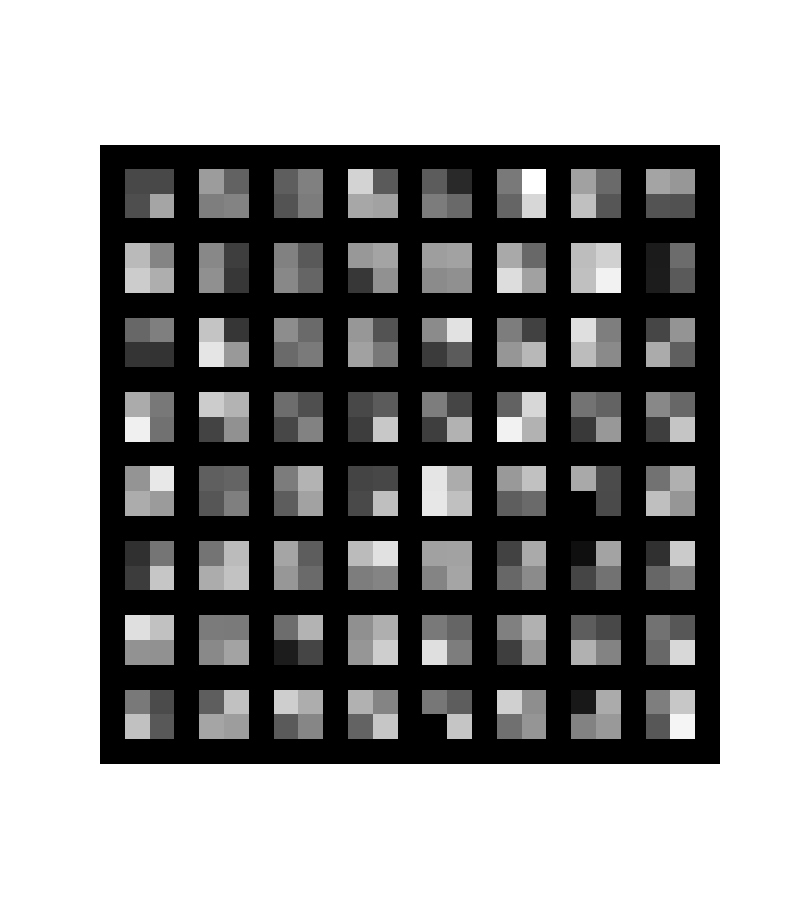

In [69]:
filter = model_weights[1].data
visTensor(filter, ch=0, allkernels=False)

### 6. Inspecting the waveforms

In [73]:
def plot_multi_spike_units(unit_ids, subplots_per_plot, spikes_per_subplot):
    num_subplots = len(unit_ids)
    num_plots = (num_subplots - 1) // subplots_per_plot + 1

    for plot_idx in range(num_plots):
        plt.figure(figsize=(30, 20))
        for subplot_idx in range(subplots_per_plot):
            idx = plot_idx * subplots_per_plot + subplot_idx
            if idx >= num_subplots:
                break
            
            unit_id = unit_ids[idx]
            spike_unit = spikes_table[spikes_table['unit_id'] == unit_id]
            spike_frames = spike_unit['spike_frame'].to_list()
            extremum_channel = spike_unit['extremum_channel'].unique()[0]
            
            if len(spike_frames) < spikes_per_subplot:
                num_spikes_to_plot = len(spike_frames)
            else:
                num_spikes_to_plot = spikes_per_subplot

            spike_frames_random = random.sample(spike_frames, num_spikes_to_plot)

            plt.subplot(5, 5, subplot_idx + 1)
            for spike_frame in spike_frames_random:
                # Get the trace
                trace_snippet = recording_cmr.get_traces(start_frame=spike_frame - 31, end_frame=spike_frame + 32)
                plt.plot(trace_snippet[:, extremum_channel])
            plt.title(f'Unit {unit_id}')
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(dataset_folder_path, f'spike_units_{plot_idx}.png'))

In [74]:
spike_units = spikes_table['unit_id'].unique()
print(spike_units)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [ ]:
plot_spike_units(spike_units, 25, 10)

---

## Phase 2: A Semi-Supervised Method

In [ ]:
peaks_folder_path = os.path.join(os.getcwd(), "peaks")
peaks_file_path = os.path.join(peaks_path, "peaks.npy")

if not os.path.exists(peaks_folder_path):
    os.mkdir(peaks_path)
    
    job_kwargs = dict(chunk_duration='1s', n_jobs=8, progress_bar=True)

    peaks = detect_peaks(
        recording_cmr,
        method='by_channel', #locally_exclusive
        peak_sign='both', #start with neg
        detect_threshold=3, #higher threshold
        **job_kwargs
    )

if not os.path.exists(peaks_file_path):
    np.save(peaks_file_path, peaks)
    
peaks = np.load(peaks_file_path)
peaks

In [ ]:
peaks_table_path = os.path.join(peaks_folder_path, "peaks_table.pkl")

if not os.path.exists(peaks_table_path):
    peaks_table = pd.DataFrame(peaks)
    peaks_table.to_pickle(peaks_table_path)

peaks_table = pd.read_pickle(peaks_table_path)
    
display(peaks_table)

In [ ]:
# Create a boolean mask to identify rows within the specified range
mask = (peaks_table['sample_ind'] >= 31) & (peaks_table['sample_ind'] <= recording_nwb.get_num_frames() - 33)

# Apply the mask to the DataFrame to keep only the rows within the range
peaks_table = peaks_table[mask]

display(peaks_table)

In [ ]:
display(spikes_table)

In [ ]:
# Set the batch size
batch_size = 1000

# Create an empty list to store the matching spike frames
peaks_spikes_frames = []

# Set the path to save the progress
peaks_spikes_frames_path = os.path.join(peaks_folder_path, "peaks_spikes_frames.pkl")

In [ ]:
# Check if progress file exists
if os.path.exists(peaks_spikes_frames_path):
    # Load the progress file
    with open(peaks_spikes_frames_path, 'rb') as f:
        peaks_spikes_frames_progress = pickle.load(f)
        start_index = peaks_spikes_frames_progress['start_index']
        peaks_spikes_frames = peaks_spikes_frames_progress['peaks_spikes_frames']
else:
    # Start from the beginning
    start_index = 0

try:
    # Iterate over the spikes table in batches
    for i in tqdm(range(start_index, len(spikes_table), batch_size), desc='Processing', unit='batch'):
        batch_spikes = spikes_table.iloc[i:i+batch_size]

        # Create a boolean mask indicating the matching frames in the current batch
        mask = np.isin(peaks_table['sample_ind'], batch_spikes['spike_frame'])

        # Filter the peaks table using the mask
        peaks_table_filtered = peaks_table[mask]

        # Calculate the absolute difference between channel indices
        diff = np.abs(peaks_table_filtered['channel_ind'].values[:, np.newaxis] - batch_spikes['extremum_channel'].values)

        # Find the indices of the matching frames within the batch
        matching_indices = np.any(diff <= 3, axis=0)

        # Append the matching spike frames to the list
        peaks_spikes_frames.extend(batch_spikes[matching_indices]['spike_frame'].tolist())
        
        # Save the progress after each batch
        peaks_spikes_frames_progress = {
            'start_index': i + batch_size,
            'peaks_spikes_frames': peaks_spikes_frames
        }
        with open(peaks_spikes_frames_path, 'wb') as f:
            pickle.dump(peaks_spikes_frames_progress, f)
            
except KeyboardInterrupt:
    # Save the progress
    peaks_spikes_frames_progress = {
        'start_index': i + batch_size,
        'peaks_spikes_frames': peaks_spikes_frames
    }
    with open(peaks_spikes_frames_path, 'wb') as f:
        pickle.dump(peaks_spikes_frames_progress, f)
    print('Processing paused. Run the script again to resume.')
    
# Check if the processing is completed
if start_index >= len(spikes_table):
    print('Processing completed. The list has been loaded.')

In [ ]:
# Set the path to save the progress
peaks_noise_frames_path = os.path.join(peaks_folder_path, "peaks_noise_frames.pkl")

# Check if the file exists
if not os.path.exists(peaks_noise_frames_path):
    peaks_noise_frames = peaks_table['sample_ind'].unique()

    # Remove frames from peaks_noise_frames that are in peaks_spikes_frames
    # Convert lists to sets
    peaks_spikes_frames_set = set(peaks_spikes_frames)
    peaks_noise_frames_set = set(peaks_noise_frames)

    # Remove frames from the noise set that exist in the spikes set
    peaks_noise_frames_set -= peaks_spikes_frames_set

    # Convert the noise set back to a list
    peaks_noise_frames = list(peaks_noise_frames_set)
    
    # Save the list as a file 
    with open(peaks_noise_frames_path, 'wb') as f:
        pickle.dump(peaks_noise_frames, f)

    del peaks_spikes_frames_set
    del peaks_noise_frames_set
    
# Load the peaks_noise_frames file
with open(peaks_noise_frames_path, 'rb') as f:
    peaks_noise_frames = pickle.load(f)

del peaks
del peaks_table